In [1]:
import tensorflow
import jax
jax.config.enable_omnistaging()
from jax import numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import ufl
from crikit import *
#import pyadjoint
#from crikit.learn import TheanoLogPdf
from theano_op import TheanoLogPdf
from crikit.observer import SubdomainObserver
from crikit.loss import SlicedWassersteinDistance
import pymc3 as pm
import theano.tensor as tt
import sys
#to prevent stack overflows in JAX functions, which can have very deep recursion
sys.setrecursionlimit(100000)

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


# Explain physics and discretization here

In [2]:
class Experiment:
    def __init__(self, mesh, alpha=0, g=9.8, rho=1):
        self.setDomainParameters(mesh,False)
        self.setF(alpha=alpha, g=g, rho=rho)

    def setF(self, alpha=None, g=None, rho=None):
        self.alpha = self.alpha if alpha is None else alpha
        self.g = self.g if g is None else g
        self.rho = self.rho if rho is None else rho
        V = VectorFunctionSpace(mesh, "CG", 2)
        f = (-self.rho * self.g * sin(self.alpha), -self.rho * self.g * cos(self.alpha), 0)
        if self.dim == 2:
            f = f[:2]
        self.f = Constant(f, name='f')

    def setDomainParameters(self, mesh, rte=False):
        if rte:
            V = FiniteElement("RT",mesh.ufl_cell(),2)
            Q = FiniteElement("DG",mesh.ufl_cell(),1)
            self.dim = mesh.geometric_dimension()
            self.W = FunctionSpace(mesh,V * Q)
        else:
            V_e = VectorElement("CG", mesh.ufl_cell(), 2)
            Q_e = FiniteElement("CG", mesh.ufl_cell(), 1)
            VQ_e = V_e*Q_e
            self.W = FunctionSpace(mesh, VQ_e)
            self.dim = V_e.value_shape()[0]

        self.rte = rte

    def setBCs(self, dir_bcs, rob_bcs=None):
        """
        Sets Dirichlet and Robin boundary conditions. Each Robin condition is a
        tuple (a, b, j, ds) corresponding to the equation :math:`a u + b mu sym(grad(u)) n = j`
        on the boundary ds. Note that the Robin conditions are only applied
        to the velocity, not the pressure.

        Args:
            dir_bcs (DirichletBC or list[DirichletBC]): The Dirichlet boundary conditions.
            rob_bcs (tuple or list[tuple]): See description above.
        """
        self.bcs = Enlist(dir_bcs)
        self.h_bcs = homogenize_bcs(self.bcs)
        self.rob_bcs = Enlist(rob_bcs) if rob_bcs is not None else None

    def bc(self, u):
        """Applies Dirichlet boundary conditions to function or to matrix"""
        if hasattr(u, 'vector'):
            for bc in self.bcs:
                bc.apply(u.vector())
        else:
            for bc in self.bcs:
                bc.apply(u)
        return u

    def h_bc(self, u):
        """Applies homogenous Dirichlet boundary conditions to function or to matrix"""
        for bc in self.h_bcs:
            bc.apply(u.vector())
        return u

    def get_robin_terms(self, u, v):
        """Adds the Robin terms to the given Form"""
        if self.rob_bcs is None:
            return 0
        F = 0
        for a, b, j, ds in self.rob_bcs:
            F += inner(v, (a * u - j))/b * ds
        return F

    def run(self, cr, observer=None, initial_w=None, ufl=False, cback=None, solver_parameters=None, disp=True):
        if solver_parameters is None:
            solver_parameters = {}

        # Define u.
        if initial_w is None:
            w = Function(self.W, name='w')
        else:
            w = initial_w

        if ufl:
            w = self._ufl_solve(cr, w, cback=cback, disp=disp)
        elif self.rte:
            w = self._rte_solve(cr, w, cback, disp)
        else:
            w = self._solve(cr, w, cback=cback, disp=disp)

        if observer is None:
            return w
        return observer(w)

    def _ufl_solve(self, cr, w, cback=None, disp=True):
        # Don't print out Newton iterations.
        if not disp:
            orig_log_level = get_log_level()
            set_log_level(LogLevel.CRITICAL)

        # Set up the weak form.
        u, p = split(w)
        sigma = cr(sym(grad(u)))
        # mu = cr(sym(grad(u)))
        # sigma = mu * sym(grad(u))
        F, u = self.get_form(w, sigma)
        params = {'nonlinear_solver' : 'snes', 'snes_solver' : {'line_search' : 'bt'}}
        solve(F == 0, w, self.bcs)#, solver_parameters=params)

        if not disp:
            set_log_level(orig_log_level)

        if cback is not None:
            cback(w)
        return w

    def _solve(self, cr, w, cback=None, disp=True):
        # Set up the weak form.
        F, u, sigma = self.get_form_cr(cr, w)     
            
        with push_tape():
            residual = Function(self.W)
            assemble_with_cr(F, cr, sym(grad(u)), sigma, tensor=residual, quad_params=quad_params)

            wcontrol = Control(w)
            residual_rf = ReducedFunction(residual, wcontrol)
            
        reduced_equation = ReducedEquation(residual_rf, self.bc, self.h_bc)

        solver = SNESSolver(reduced_equation, {'jmat_type': 'assembled'})
        #get_working_tape().visualise_dot('tape.dot')
        w = solver.solve(wcontrol, disp=disp, cback=cback)
        return w


    def _rte_solve(self, cr, w, cback=None, disp=True):

        F, u, sigma = self.get_rte_form_cr(cr,w)

        with push_tape():
            res = Function(self.W)
            assemble_with_cr(F,cr,u,sigma,tensor=res,quad_params=quad_params)
            wcontrol = Control(w)
            res_rf = ReducedFunction(res,wcontrol)

        red_eq = ReducedEquation(res_rf,self.bc,self.h_bc)

        solver = SNESSolver(red_eq,{'jmat_type' : 'assembled'})
        w = solver.solve(wcontrol,disp=disp,cback=cback)
        return w

    def get_rte_form_cr(self, cr, w):
        target_shape = tuple(i for i in cr.target.shape() if i != -1)
        # mu = create_ufl_standins((target_shape,))[0]
        sigma = create_ufl_standins((target_shape,))[0]
        u, p = split(w)
        # sigma = mu * sym(grad(u))
        F, u = self.get_rte_form(w, sigma)
        return F, u, sigma

    def get_form_cr(self, cr, w):
        target_shape = tuple(i for i in cr.target.shape() if i != -1)
        # mu = create_ufl_standins((target_shape,))[0]
        sigma = create_ufl_standins((target_shape,))[0]
        u, p = split(w)
        # sigma = mu * sym(grad(u))
        F, u = self.get_form(w, sigma)
        return F, u, sigma


    def get_rte_form(self, w, sigma):
        u, p = split(w)
        w_test = TestFunction(self.W)
        v, q = split(w_test)
        a = (inner(dot(inv(sigma),u), v) -
             inner(p,div(v)) - inner(div(u),q)) * dx
        L = inner(self.f,v) * dx
        F = a - L + self.get_robin_terms(u,v)
        return F, u

    def get_form(self, w, sigma):
        u, p = split(w)
        w_test = TestFunction(self.W)
        v, q = split(w_test)

        lhs = (inner(sigma, grad(v)) * dx
               - inner(div(v), p) * dx
               - inner(div(u), q) * dx
              )
        rhs = inner(self.f, v) * dx
        F = lhs - rhs
        F = F + self.get_robin_terms(u, v)
        return F, u

In [3]:
#set up the experiment --- these parameters define the experiment, so play around with them and see what happens!
dims = 2 #must be 2 or 3
grid_sizes = [5] * dims # N x N mesh in 2d, N x N x N mesh in 3d
angle_rads = -np.pi / 6
rho = 1
g = 9.8
p_true = 1.2 # true value of p. Must be > 1. Values in [1,2] require larger regularization than values in (2,\infty)
epsilon = 0.1 # regularization -- if you get NaNs during the optimization process, this is probably too small
fe_order = 2 # finite element order; must be >= 2
robin_bcs = True #use Robin boundary conditions?
robin_a = 1
robin_b = 0.5
seed = 10
cmap = 'magma' #plot color map
display_snes_iterations = True #display iterations in the nonlinear solver? useful for debugging and progress tracking

In [4]:


if dims == 2:
    mesh = UnitSquareMesh(*grid_sizes)
    inflow = Expression(("x[1]*(1-x[1])/2", "0"), degree=2)
    def side_boundary(x, on_boundary):
        return on_boundary and (near(x[1], 0, 1e-5) or near(x[1], 1, 1e-5))
else:
    mesh = UnitCubeMesh(*grid_sizes)
    inflow = Expression(("x[1]*(1-x[1])/2 * x[2]*(1-x[2])/2", "0", "0"), degree=2)
    def side_boundary(x, on_boundary):
        return on_boundary and (near(x[1], 0, 1e-5) or near(x[1], 1, 1e-5)
                                or near(x[2], 0, 1e-5) or near(x[2], 1, 1e-5))
    
def inflow_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0, 1e-5)

def outflow_boundary(x, on_boundary):
    return on_boundary and near(x[0], 1, 1e-5)

class OutflowBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return outflow_boundary(x, on_boundary)
    
#boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1, 0)
#OutflowBoundary().mark(boundary_markers, 1)
#de = ds(1, domain=mesh, subdomain_data=boundary_markers)
observer = SubdomainObserver(mesh, OutflowBoundary())#SurfaceObserver(de)

noslip = ufl.zero(dims)
eps2 = epsilon ** 2
ex = Experiment(mesh, alpha=angle_rads, g=g)#angle_radians=angle_rads, g=g, fe_order=fe_order)
ex2 = Experiment(mesh, alpha=angle_rads/2, g=g)

if robin_bcs:
    class InflowBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return inflow_boundary(x, on_boundary)
        
    class SideBoundary(SubDomain):
        def inside(self, x, on_boundary):
            return side_boundary(x, on_boundary)
        
    markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1, 0)
    InflowBoundary().mark(markers, 1)
    SideBoundary().mark(markers, 2)
    dleft = ds(1, domain=mesh, subdomain_data=markers)
    dside = ds(2, domain=mesh, subdomain_data=markers)
    robin_a = Constant(robin_a)
    robin_b = Constant(robin_b)
    ex.setBCs([],
              [(robin_a, robin_b, inflow, dleft),
               (robin_a, robin_b, noslip, dside),
              ]
             )
    ex2.setBCs([],
              [(robin_a, robin_b, inflow, dleft),
               (robin_a, robin_b, noslip, dside),
              ]
             )
else:
    noslip = Expression(("0",)*dims, degree=0) #NOTE: do I actually need to do this?
    ex.setBCs([DirichletBC(ex.W.sub(0), noslip, side_boundary),
               DirichletBC(ex.W.sub(0), inflow, inflow_boundary)])
    ex2.setBCs([DirichletBC(ex.W.sub(0), noslip, side_boundary),
               DirichletBC(ex.W.sub(0), inflow, inflow_boundary)])
    
quad_params = {'quadrature_degree' : fe_order + 1}
domain = mesh.ufl_domain()
#sets parameters for the crikit.covering module
set_default_covering_params(domain=domain, quad_params=quad_params)

cmap = cm.get_cmap(cmap)

The true CR that we'll be trying to learn is 
$$
\sigma = (\mathrm{tr}(F\cdot F )+ \epsilon ^ 2)^{( p - 2) / 2} F
$$
where $F = \frac{\nabla\mathbf{u} + \nabla\mathbf{u}^T}{2}$ and $\epsilon$ is a regularization constant. This is known as a _p-laplacian_ CR.

In [5]:
#let's see what noise distributions are availablef
AdditiveRandomFunction.available_distributions()

['bernoulli',
 'cauchy',
 'dirichlet',
 'double_sided_maxwell',
 'exponential',
 'gamma',
 'gumbel',
 'laplace',
 'logistic',
 'maxwell',
 'multivariate_normal',
 'normal',
 'pareto',
 'poisson',
 'rademacher',
 't',
 'truncated_normal',
 'uniform',
 'weibull']

Text(0.5, 1.0, 'Noisy solution with true CR, with p = 1.2')

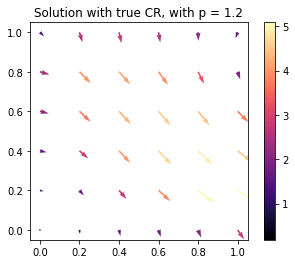

<Figure size 432x288 with 0 Axes>

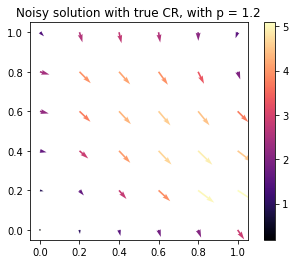

In [6]:
p = Constant(p_true, name='p')
def true_cr(epsilon):
    scalar_invt = tr(dot(epsilon, epsilon))
    mu = (scalar_invt + eps2) ** ((p - 2) / 2)
    return mu * epsilon
    

#generate the observations!
with record_tape_block(name='Ground Truth Experiment'):
    w = ex.run(true_cr, ufl=True, observer=None, disp=display_snes_iterations)
    obs_w = observer(w)
    
#with record_tape_block(name='Ground Truth Experiment (Half Angle)'):
#    w2 = ex2.run(true_cr, ufl=True, observer=None, disp=display_snes_iterations)
#    obs_w2 = observer(w2)
    
plt.figure()
u, p = w.split()
plt.colorbar(plot(u, cmap=cmap))
plt.title(f"Solution with true CR, with p = {p_true}")
plt.figure()
#u, p = w2.split()
#plt.colorbar(plot(u, cmap=cmap))
#plt.title(f"Solution with true CR at double angle, with p = {p_true}")
#u, p = w.split()
noise_maker = AdditiveRandomFunction(ex.W, std=0.0, seed=seed)
noisy_w = noise_maker(w)
#let's say we have a few IID obs per experiment
num_obs_per = 1
noisy_ws = [observer(noise_maker(w)) for _ in range(num_obs_per)]
#noisy_w2s = [noise_maker(w2) for _ in range(num_obs_per)]
noisy_u, noisy_p = noisy_w.split()
plt.figure()
plt.colorbar(plot(noisy_u, cmap=cmap))
plt.title(f"Noisy solution with true CR, with p = {p_true}")

Now we can define our JAX-based CRs, which we'll use to learn MAP estimates for the parameters $\theta$, a two-component vector. The first component is a scale component called $a$, and the second component is $p$. 

Defining a JAX CR is very easy, and you have two options as to how to do it. Regardless of which approach you take, you will have to define your inputs as a list or tuple of `crikit.invariants.TensorType` instances, as well as a `TensorType` representing the output of your CR function. The first approach is to write a function that represents your CR in the form
$$
\sigma = \sum\limits_i \phi_i(I_S(A, B, \ldots ); \theta) F_i(A, B, \ldots )
$$
where $I_S(A, B, \ldots )$ are scalar values that are invariant under symmetry transformations of the inputs $A, B, \ldots$ (i.e. under the orthogonal or special orthogonal group over all the inputs) called <em>scalar invariants</em>, $F_i$ are so-called <em>form invariants</em>, tensors with the same `TensorType` representation as $\sigma$ that are themselves equivariant (not <em>invariant</em>, despite their name!) under the same symmetry transformations, and $\phi_i$ are scalar-valued functions. $\theta$ are the parameters passed to the `CR` constructor. The `crikit.invariants` module computes the $I_S$ and $F_i$ functions for you; all you need to provide is a function to compute the $\phi_i$, and provide them in a one-dimensional JAX array. If your material is not isotropic like the one modeled here is, you should pass the structural tensor representing that anisotropy as one of your inputs, and add a corresponding `TensorType` describing that structural tensor as one of your input types. If that tensor is the Levi-Civita tensor, use a `LeviCivitaType` to represent it, but don't pass in a concrete (i.e. array or `Function`) representation to the `CR` when evaluating it or using `assemble_with_cr()`; the `CR` will account for its presence when determining the invariants.


The other approach to building a `CR` is to represent it with a <em>strain-energy density</em>,
$$
W = \phi(I_S(A, B, \ldots); \theta)
$$
where $\phi$ is a scalar-valued function of the scalar invariants and parameters. The `CR` will then use JAX to differentiate the strain-energy density with respect to the first input, which should be the (symmetric) strain tensor to get a stress tensor $\sigma$. If you do this, be sure to pass `strain_energy=True` to the `CR` constructor, because it is also possible to construct a scalar-valued `CR` which will not differentiate the function you pass it.

The value $\mathrm{tr}(F\cdot F)$ is the second scalar invariant, which makes writing the JAX versions of the true CR easy:

In [7]:
theta = array([0.95, 1.15]) #initial guess as to the scale parameter (0.9 by default) and p (1.5 by default)

In [8]:
def jax_form_invariant_cr_func(scalar_invts, theta):
    #a JAX-based CR that uses form invariants
    a, p = theta[0], theta[1]
    scale = a * (scalar_invts[1] + eps2) ** ((p - 2) / 2)
    return jnp.array([0, scale])

def jax_energy_cr_func(scalar_invts, theta):
    #a JAX-based CR that calculates the strain energy and gets the stress by differentiating
    #it w.r.t. the input tensor
    a, p = theta[0], theta[1]
    return (a / p) * (scalar_invts[1] + eps2) ** (p / 2)

input_types = (TensorType.make_symmetric(2, dims),)
output_type = TensorType.make_symmetric(2,dims)#scalar()#
form_invt_cr = CR(output_type, input_types,
                 jax_form_invariant_cr_func, params=(theta,))

strain_energy_cr = CR(TensorType.make_scalar(), input_types, 
                      jax_energy_cr_func, params=(theta,),
                      strain_energy=True)

In [9]:
#compute the loss for the form-invariant CR
#observer = lambda x: x.copy(deepcopy=True)
with record_tape_block(name='JAX Form Invariant Experiment'):
    pred_w = ex.run(form_invt_cr, observer=observer, ufl=False, disp=False)

#with record_tape_block(name='JAX Form Invariant Experiment'):
#    pred_w2 = ex2.run(form_invt_cr, observer=observer, ufl=False, disp=False)
    
#def loss(pred, pred2):
#    return integral_loss(pred, observer(noisy_ws[0]))# + integral_loss(pred2, observer(noisy_w2s[0]))
loss = integral_loss#SlicedWassersteinDistance(noisy_ws[0], pred_w, 10, jax.random.PRNGKey(seed))
err = loss(noisy_ws[0], pred_w)#observer(noisy_ws[0]), pred_w) #pred_w2)
print("Initial loss is ", err)
#define the functional to minimize
Jhat = ReducedFunctional(err, Control(theta))

Initial loss is  0.03580712314141715


In [10]:
#now do the same for the energy CR
with record_tape_block(name='JAX Energy Invariant Experiment'):
    pred_w_e = ex.run(strain_energy_cr, observer=observer, ufl=False, disp=False)
    
err_energy = integral_loss(obs_w, pred_w_e)
print("Initial loss with energy CR is ", err_energy)
Jhat_e = ReducedFunctional(err_energy, Control(theta))

Initial loss with energy CR is  0.03580712314141732


# Computing MAP estimates

Now that we have defined our CRs and computed our loss functionals (`Jhat` and `Jhat_e`), we can minimize the loss to find the Maximum A Posteriori (i.e. maximum likelihood) estimate of the parameters $\theta = [a,p]$. We do this with `pyadjoint.minimize()`, which itself calls `scipy.optimize.minimize()`. Further, note that we have used both methods for defining a callback: we pass a callback function to `minimize()` in the form of `minimize_cb` in order to view the state and loss at each iteration of the optimizer, and setting `Jhat.eval_cb_pre` to view the state each time we re-evaluate the `ReducedFunctional`.

In [11]:
logfile_name = 'form_invariant_opt.csv'#change this if desired
num_entries = -1 #changes to 0 when the file is opened
logfile = None
total_num_call = 0

In [12]:


def log_reset():
    global total_num_call, num_entries, logfile
    logfile.close()
    total_num_call = 0
    num_entries = -1

def log_init(name):
    global num_entries, logfile
    if num_entries > -1:
        raise ValueError("Must set num_entries to -1 before initializing logging!")
    
    logfile = open(name, 'w+')
    num_entries = 0
    param_name_str = ','.join(['param_' + str(i) for i in range(theta.size)])
    grad_name_str = ','.join(['grad_param_' + str(i) for i in range(theta.size)])
    logfile.write('step,loss,' + param_name_str + ',' + grad_name_str + '\n')
    
    
def log_entry(Jhat, params):
    global num_entries, logfile
    if num_entries < 0:
        raise Exception("Must initialize logging before logging an entry!")
        
    loss = Jhat.functional.block_variable.checkpoint
    param_str = ','.join(map(str, np.array(params.flatten())))
    grad = Jhat.controls[0].get_derivative()
    grad_str = ','.join(map(str, np.array(grad)))
    print(f"writing entry {str(num_entries) + ',' + str(loss) + ',' + param_str + ',' + grad_str}")
    logfile.write(str(num_entries) + ',' + str(loss) + ',' + param_str + ',' + grad_str + '\n')
    num_entries += 1

def minimize_cb(x_k, state=None):
    log_entry(Jhat, x_k)
    
    
def cb_pre(x):
    global total_num_call
    total_num_call += 1
    print("calls: ", total_num_call, " theta: ", x)
    
h = 1e-2 * array(np.random.randn(*theta.shape))
#get_working_tape().visualise('logs', True, True)
assert taylor_test(Jhat, theta, h) >= 1.9
#Jhat.eval_cb_pre = cb_pre
#we know that the PDE is ill-posed for p < 1, so give it a little padding to be safe
bounds = [array([0.9, 1.05]), array([1.05, 1.5])]
#log_init('wasserstein_' + logfile_name)
map_estimate = minimize(Jhat, method='L-BFGS-B', callback=None, bounds=bounds, options={'disp' : True})
#print("Total number of function evaluations: ", total_num_call)
#log_reset()
print("MAP estimate is ", map_estimate)

Computing derivative
Running Taylor test
Computed residuals: [6.62202323434795e-08, 1.656049900547262e-08, 4.140805184168036e-09, 1.0352865783472813e-09]
Computed convergence rates: [1.9995259274800823, 1.9997629114034543, 1.9998811523018478]
MAP estimate is  [1.00434388 1.1993575 ]


# Explain log-pdf and HMC

In [13]:
stdev = 0.1
p_lower_bound = 1.05
p_upper_bound = 1.5
p_prior_stdev = 0.2
a_prior_stdev = 0.2
a_lower_bound = 0.8
a_upper_bound = 1.2
n_samples = 1200
n_burn_in = 400
n_chain = 1

In [14]:
#err is actually squared error
@overload_jax
def logpdf(err):
    return - err  / (2 * stdev ** 2)

def reset_params(rf, params):
    for i in range(len(params)):
        rf.controls[i].update(params[i])

logpdf_op = TheanoLogPdf(ReducedFunctional(logpdf(err), Control(theta)), (theta,))
err_op = TheanoLogPdf(ReducedFunctional(err, Control(theta)), (theta,))
J = logpdf_op.rf(theta)
thetamha = theta - jnp.array([4.0e-6, 0])
thetamhp = theta - jnp.array([0, 4.0e-6])
thetapha = theta + jnp.array([4.0e-6, 0])
thetaphp = theta + jnp.array([0, 4.0e-6])
thetaphap = theta + jnp.array([4.0e-6, 4.0e-6])
thetamhap = theta - jnp.array([4.0e-6, 4.0e-6])
reset_params(logpdf_op.rf, [thetamha])
Jmha = logpdf_op.rf(thetamha)
reset_params(logpdf_op.rf, [thetapha])
Jpha = logpdf_op.rf(thetapha)
H_aa = (Jpha - 2 * J + Jmha) / (4.0e-6) ** 2
print("H_aa = ", H_aa)
reset_params(logpdf_op.rf, [thetamhp])
Jmhp = logpdf_op.rf(thetamhp)
reset_params(logpdf_op.rf, [thetaphp])
Jphp = logpdf_op.rf(thetaphp)
H_pp = (Jphp - 2 * J + Jmhp) / 4.0e-6 ** 2
print("H_pp = ", H_pp)

#Jphap = logpdf_op.rf(thetaphap)
H_pa = (logpdf_op.rf(theta + jnp.array([4.0e-6, 4.0e-6])) 
        - logpdf_op.rf(theta + jnp.array([4.0e-6, -4.0e-6])) 
        - logpdf_op.rf(theta + jnp.array([-4.0e-6, 4.0e-6]))
        + logpdf_op.rf(theta + jnp.array([-4.0e-6, -4.0e-6]))
        ) / (4 * 4.0e-6 ** 2)
print("H_pa = ", H_pa)
H = jnp.zeros((2,2))
H = jax.ops.index_update(H, jax.ops.index[0,0], -H_aa)
H = jax.ops.index_update(H, jax.ops.index[0,1], -H_pa)
H = jax.ops.index_update(H, jax.ops.index[1,0], -H_pa)
H = jax.ops.index_update(H, jax.ops.index[1,1], -H_pp)
print(H)
#fisher_info = jnp.tensordot(J.value, J.value,axes=0)
print(jnp.linalg.eigh(H))
#tt.verify_grad(logpdf_op, [np.array(map_estimate)], rng=np.random, rel_tol=0.01, abs_tol=0.01)

H_aa =  -528.6991955344433
H_pp =  -2953.5321272033957
H_pa =  -1210.7752127288318
[[ 528.69919553 1210.77521273]
 [1210.77521273 2953.5321272 ]]
(DeviceArray([  27.66000032, 3454.57132242], dtype=float64), DeviceArray([[-0.92400908,  0.38237053],
             [ 0.38237053,  0.92400908]], dtype=float64))


In [ ]:
def convert(x):
    if isinstance(x, ndarray):
        return x.unwrap(True)
    return x 
    
def value_grad_and_hessian(rf, theta, h=0.001):
    J = rf(theta)
    gradJ = rf.derivative()
    thetamha = theta - jnp.array([h, 0])
    thetamhp = theta - jnp.array([0, h])
    thetapha = theta + jnp.array([h, 0])
    thetaphp = theta + jnp.array([0, h])
    thetaphap = theta + jnp.array([h, h])
    thetamhap = theta - jnp.array([h, h])
    Jmha = rf(thetamha)
    Jpha = rf(thetapha)
    Jmhp = rf(thetamhp)
    Jphp = rf(thetaphp)
    H_aa = (Jpha - 2 * J + Jmha) / h ** 2
    H_pp = (Jphp - 2 * J + Jmhp) / h ** 2
    H_pa = (rf(thetaphap)
            - rf(theta + jnp.array([h, -h]))
            - rf(theta + jnp.array([-h, h]))
            + rf(thetamhap)
            ) / (4 * h ** 2)
    H = jnp.zeros((2,2))
    H = jax.ops.index_update(H, jax.ops.index[0,0], H_aa)
    H = jax.ops.index_update(H, jax.ops.index[0,1], H_pa)
    H = jax.ops.index_update(H, jax.ops.index[1,0], H_pa)
    H = jax.ops.index_update(H, jax.ops.index[1,1], H_pp)
    return J, convert(gradJ), H


def find_saddle_point(rf, theta0, atol=1.0e-16, max_iter=50):
    theta = theta0
    
    for _ in range(max_iter):
        f, gradf, hess_f = value_grad_and_hessian(rf, theta)
        evals, evecs = jnp.linalg.eigh(hess_f)
        print("Theta", theta, "Function value:", f, "Gradient: ", gradf, "Hessian eigenvalues:", evals, "Hessian eigenvectors:", evecs)
        if jnp.linalg.norm(gradf) < atol:
            return theta
        p = jnp.linalg.solve(hess_f, gradf)
        p = p / jnp.linalg.norm(p)
        theta = theta - 0.01 * p
        

    return theta

with stop_annotating():
    find_saddle_point(Jhat, array([0.97, 1.25]))

In [17]:
!pip uninstall -y pymc3
!pip install git+https://github.com/OriolAbril/pymc3.git

/usr/bin/fish: /home/diffeoinvariant/anaconda3/envs/fenics2019/lib/libtinfo.so.6: no version information available (required by /usr/bin/fish)
Found existing installation: pymc3 3.11.1
Uninstalling pymc3-3.11.1:
  Successfully uninstalled pymc3-3.11.1
/usr/bin/fish: /home/diffeoinvariant/anaconda3/envs/fenics2019/lib/libtinfo.so.6: no version information available (required by /usr/bin/fish)
  Cloning https://github.com/OriolAbril/pymc3.git to /tmp/pip-req-build-u7e8oe1m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pymc3: filename=pymc3-3.11.1-py3-none-any.whl size=869270 sha256=71ef38064142655efa6e3e59b85ad73d7f2ca519e9e2730fd6536e00987d5f84
  Stored in directory: /tmp/pip-ephem-wheel-cache-ft45i9w_/wheels/f8/62/da/9c4d3ea37a00328c41ff837ab769cc70c0b50b50f9a9c2042f
Successfully built pymc3


In [15]:
#H = -H
logpdf_op.n = 0
print("Hessian : ", H)
print("Hinv : ", jnp.linalg.inv(H))
#db = pm.backends.Text(f"db_trace{n_samples}_burn{n_burn_in}_chains{n_chain}_seed{seed}_outflow")
with pm.Model() as energy_sampler:
    rv_p = pm.Bound(pm.Normal, lower=p_lower_bound, upper=p_upper_bound)("p",mu=map_estimate[1] , sigma=p_prior_stdev)
    rv_a = pm.Bound(pm.Normal, lower=a_lower_bound, upper=a_upper_bound)("a", mu=map_estimate[0], sigma=a_prior_stdev)
    
    rv_theta = tt.as_tensor_variable([rv_a, rv_p])
    #OriolArbil's fork (https://github.com/OriolAbril/pymc3/tree/density_dist) lets us use givens instead of observed
    pm.DensityDist("log-likelihood", lambda x: logpdf_op(x), givens={'x' : rv_theta})
    #err_mu
    trace = pm.sample(n_samples, step=pm.NUTS(rv_theta, scaling=jnp.linalg.inv(H), is_cov=True), tune=n_burn_in, cores=1, chains=n_chain, compute_convergence_checks=False, return_inferencedata=False)
    pm.save_trace(trace, f"trace{n_samples}_burn{n_burn_in}_chains{n_chain}_seed{seed}_outflow_wider_a", overwrite=True)

Hessian :  [[ 528.69919553 1210.77521273]
 [1210.77521273 2953.5321272 ]]
Hinv :  [[ 0.03090974 -0.01267118]
 [-0.01267118  0.00553302]]


TypeError: __init__() got an unexpected keyword argument 'givens'

In [ ]:
 with energy_sampler:
    pm.save_trace(trace, f"trace{n_samples}_burn{n_burn_in}_chains{n_chain}_seed{seed}_backup", overwrite=True)

In [ ]:
with energy_sampler:
    #pm.sampling.iter_sample

In [ ]:
df = pm.backends.tracetab.trace_to_dataframe(trace)

In [ ]:
sum(trace.get_sampler_stats('process_time_diff')) / 3600

In [ ]:
trace.get_sampler_stats('tree_size')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pt = trace.get_values('p')
at = trace.get_values('a')

In [ ]:
fig_p = sns.kdeplot(trace['p'])
fig_p.set_title('Posterior Marginal Distribution of p')
plt.savefig('marginal_posterior_p.png')

In [ ]:
plt.figure()
fig_a = sns.kdeplot(trace['a'])
fig_a.set_title('Posterior Marginal Distribution of a')
plt.savefig('marginal_posterior_a.png')

In [ ]:
joint_fig = sns.jointplot(data=df, x='p', y='a', color='c')#trace['p'], trace['a'], kind='kde', color='r')
joint_fig.plot_joint(sns.kdeplot, color='r')
joint_fig.savefig('joint_posterior_cyan.png')

In [ ]:
az.ess(trace)

In [ ]:
pm.ess(trace)

In [ ]:
import arviz as az

In [ ]:
with energy_sampler:
       trace2 = az.from_pymc3(trace)#az.load_arviz_data(f"trace{n_samples}_burn{n_burn_in}_chains{n_chain}_seed{seed}_outflow")

In [ ]:
!ls trace*outflow/0